## To do

- Agree on a title naming approach (e.g. do we keep "Laugh test X:", do we want to include the main reference in the title)
- Check the expectations for this laugh test and update the image accordingly
- Agree on what constitutes relevant meta data for these things
- Update results with Reza's new ones
- Do we want the code to be more elegant in terms of extracting length of data series, convert time from the .nc attributes etc?
- Image format and specs?

# Laugh test 5: Water movement through snow - fluxes
This notebook plots SUMMA simulations for the test case defined in in Clobeck (1976) and further developed in Clark et al. (2017).

## Expectations
The simulations are compared to analytical solutions.

## Workflow
- Specify where numerical results can be found
- Set up the analytical solution
- Loop through the experiments and ...
    - Compute analytical solution
    - Extract `scalarRainPlusMelt` variable from numerical results
    - Plot both

## Meta data

| Data  | Value  |
|:---|:---|
| Model name| Structure for Unifying Multiple Modelling Alternatives (SUMMA) |
| Model version  |   |
| Model reference | Clark et al. (2015a,b) |
| Model runs by | M. Clark |
| Model decisions | see attributes in output.nc  |
| Model run date | see attributes in output.nc |
| Notebook code by | W. Knoben, A. Bennett |
    
## Reference(s)
Clark, M. P., Nijssen, B., Lundquist, J. D., Kavetski, D., Rupp, D. E., Woods, R. A., … Rasmussen, R. M. (2015a). A unified approach for process-based hydrologic modeling: 1. Modeling concept. Water Resources Research, 51(4), 2498–2514. https://doi.org/10.1002/2015WR017198

Clark, M. P., Nijssen, B., Lundquist, J. D., Kavetski, D., Rupp, D. E., Woods, R. A., … Marks, D. G. (2015b). A unified approach for process-based hydrologic modeling: 2. Model implementation and case studies. Water Resources Research, 51, 2515–2542. https://doi.org/10.1002/2015WR017200

Clark, M. P., B. Nijssen, and C. H. Luce (2017), An analytical test case for snow models, Water Resour. Res., 53, 909–
922, doi:10.1002/2016WR019672.

Colbeck, S., and E. A. Anderson (1982), The permeability of a melting snow cover, Water Resour. Res., 18(4), 904–908, doi:10.1029/WR012i003p00523

In [1]:
# modules
from pathlib import Path
from matplotlib.ticker import MultipleLocator
import xarray as xr # note, also needs netcdf4 library installed
import matplotlib.pyplot as plt
import numpy as np
import sys

## Specify numerical results

In [2]:
# Specify the data locations relative to the notebook
sim_path = Path("./output")
sim_file = ['colbeck1976-exp1_output_timestep.nc', 'colbeck1976-exp2_output_timestep.nc', 'colbeck1976-exp3_output_timestep.nc']

In [3]:
# Define the sub-selection to extract
hru_idx = 0 # there's only 1 HRU but this turns a 3D dataframe into 2D, which is easier with plotting

## Analytical solution setup

In [4]:
# Specify if we want print statements
printFlag = 0

In [5]:
# Define constants
gravity      =       9.80616  # acceleration of gravity              (m s-2)
Cp_air       =    1005        # specific heat of air                 (J kg-1 K-1)
Cp_ice       =    2114        # specific heat of ice                 (J kg-1 K-1)
Cp_soil      =     850        # specific heat of soil                (J kg-1 K-1)
Cp_water     =    4181        # specific heat of liquid water        (J kg-1 K-1)
dynVisc      =       0.001781 # dynamic viscosity of water           (kg m-1 s-1)
Tfreeze      =     273.16     # temperature at freezing              (K)
LH_fus       =  333700        # latent heat of fusion                (J kg-1)
LH_vap       = 2501000        # latent heat of vaporization          (J kg-1)
LH_sub       = 2834700        # latent heat of sublimation           (J kg-1)
iden_air     =       1.293    # intrinsic density of air             (kg m-3)
iden_ice     =     917        # intrinsic density of ice             (kg m-3)
iden_water   =    1000        # intrinsic density of liquid water    (kg m-3)
secprday     =   86400        # number of seconds in a day

In [6]:
# Define domain
depth       =   1   # snow depth (meters)
snowDensity = 300   # snow density (kg m-3)

In [7]:
# Define flux
rainfall  = 10**(-5)    # rainfall (m s-1)
duration  = 10800       # duration of rainfall flux (seconds)
startRain = 0           # start of rainfall

In [8]:
# Define exponent in flux parameterization
n = 3

In [9]:
# Define initial relative water content for the 3 different test cases (ripe, refrozen, fresh snow)
Sw = np.array([0.07, 0, 0])

**Note:** the following calculations are done for the three test cases simultaneously

In [10]:
# Define porosity
porosityVec = (snowDensity - iden_ice) / (iden_water*Sw - iden_ice)
if printFlag: print('porosity = ' + str(porosityVec))

In [11]:
# Define the volumetric fraction of liquid water
volFracLiq = Sw*porosityVec
if printFlag: print('volFracLiq = ' + str(volFracLiq))

In [12]:
# Define the volumetric fraction of ice
volFracIce = 1 - porosityVec
if printFlag: print('volFracIce = ' + str(volFracIce))

In [13]:
# Compute fraction of liquid water
volFracTot = volFracIce*iden_ice/iden_water + volFracLiq
fracLiquid = volFracLiq/volFracTot
if printFlag: print('fracLiquid = ' + str(fracLiquid))

In [14]:
# Compute temperature based on the fraction of liquid water (K)
fc_param = 50 
ripeTemp = Tfreeze - ((1/fracLiquid[0] - 1)/fc_param**2)**(0.5)
if printFlag: print('ripeTemp = ' + str(ripeTemp))
print('\033[1m' + 'NOTE:' + '\033[0m' + ' should we explain why this is only done for ripe snow?')

NOTE: should we explain why this is only done for ripe snow?


In [15]:
# Refine residual liquid water content
residLiqVec = Sw[0]*porosityVec
if printFlag: print('residLiqVec' + str(residLiqVec))

print('\n\033[1m' + 'NOTE:' + '\033[0m' + ' this equation is written as "Sw[0]*porosityVec" in the IDL code, ', 
      'calculating "residLiqVec" for all three experiments using the Initial relative water content Sw[0] ' ,
      'of the first experiment only. We need to clarify why this is done, because the result of Sw*porosityVec ',
      'is obviously different from the approach used here. See below')
print('Sw =          ' + str(Sw))
print('porosityVec = ' +str(porosityVec))
print('Sw*porosityVec =    ' + str(Sw*porosityVec))
print('Sw[0]*porosityVec = ' + str(Sw[0]*porosityVec))


NOTE: this equation is written as "Sw[0]*porosityVec" in the IDL code,  calculating "residLiqVec" for all three experiments using the Initial relative water content Sw[0]  of the first experiment only. We need to clarify why this is done, because the result of Sw*porosityVec  is obviously different from the approach used here. See below
Sw =          [0.07 0.   0.  ]
porosityVec = [0.72845336 0.67284624 0.67284624]
Sw*porosityVec =    [0.05099174 0.         0.        ]
Sw[0]*porosityVec = [0.05099174 0.04709924 0.04709924]


In [16]:
# Define experiments
expName   = ['Ripe snow', 'Refrozen snow', 'Fresh snow']    # experiment name
grainSize = np.array([ 2.0, 2.0, 0.2]) / 1000               # grain size (m)
snowTemp  = np.array([ripeTemp, -5 + Tfreeze, -5 + Tfreeze])# temperature (K)
thetaLiq  = volFracLiq                                      # initial volumetric fraction of liquid water (-)

## Loop through experiments and plot

In [17]:
# Ensure that we can actually read the figure labels
font = {'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font);

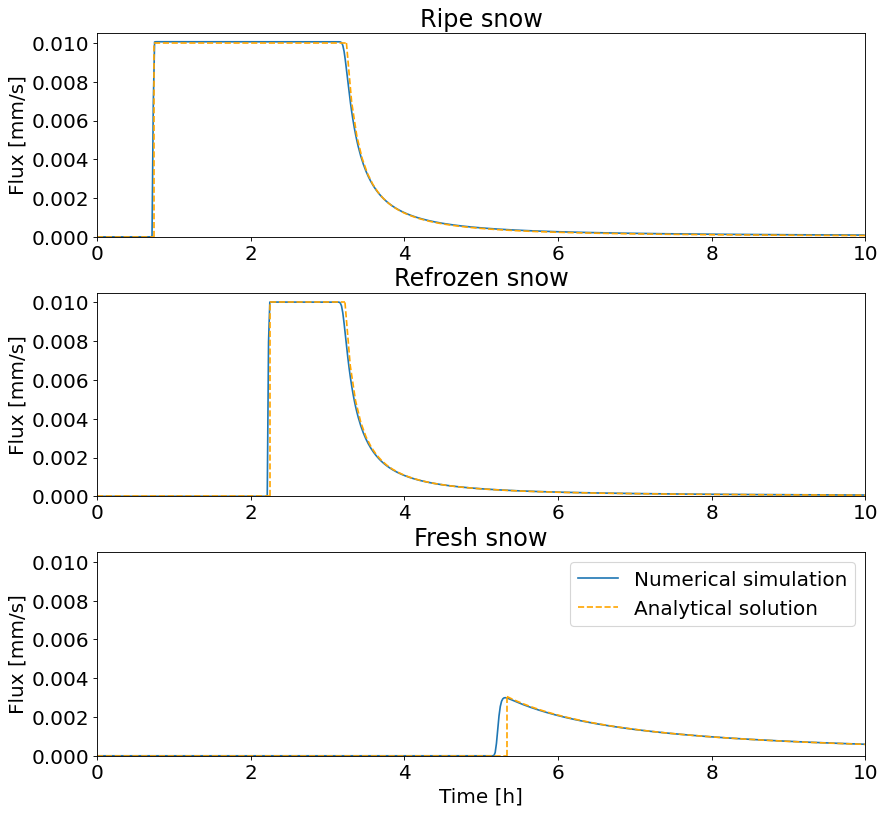

In [18]:
# Open a figure
fig, ax = plt.subplots(3,1, figsize=(11, 10), dpi= 80, facecolor='w', edgecolor='k');
fig.tight_layout()          # Switch to more spacious layout

# Loop through experiments
for iExp in range(0,3):

    # Enable/disable prints for the analytical solution
    printFlag = 0
    
    # print the experiment name
    if printFlag: print(expName[iExp])

    # ----- COMPUTE THE VARIABLES OF THE ANALYTICAL SOLUTION -----
    # get porosity and residual liquid water content
    porosity = porosityVec[iExp]
    residLiq = residLiqVec[iExp]
    
    # ----- Calculate variables -----
    # compute hydraulic conductivity (m s-1)
    permeability = grainSize[iExp]**2 * 0.077*np.exp(-7.8*snowDensity/iden_water)  # permeability (m2)
    conductivity = permeability*iden_water*gravity/dynVisc                      # hydraulic conductivity (m s-1)
    if printFlag: print('ratio           = ', str(permeability/grainSize[iExp]**2))
    if printFlag: print('grainsize^2     = ', str(grainSize[iExp]**2))
    if printFlag: print('permeability    = ', str(permeability))
    if printFlag: print('conductivity    = ', str(conductivity))
    
    # define the volumetric fraction of water required to maintain the speed of the wetting front
    satRequire   = (rainfall/conductivity)**(1/n)
    thetaRequire = residLiq + satRequire*(porosity - residLiq) - thetaLiq[iExp]
    if printFlag: print('residLiq        = ' + str(residLiq))
    if printFlag: print('porosity        = ' + str(porosity))
    if printFlag: print('satRequire      = ' + str(satRequire))
    if printFlag: print('thetaRequire    = ' + str(thetaRequire))
    
    # define the level of saturation necessary to satisfy thermal requirements
    heatRequire = (snowTemp[iExp] - Tfreeze)*(porosity - 1) * iden_ice*Cp_ice/(iden_water*LH_fus)
    if printFlag: print('heatRequire     = ' + str(heatRequire))
    
    # compute the time required for the wetting front to reach the bottom of the snowpack
    watRequire      = depth*(thetaRequire + heatRequire)  # water required so the entire profile = thetaRequire (m)
    timeWetting     = watRequire/rainfall
    celerityWetting = depth/timeWetting
    if printFlag: print('watRequire      = ' + str(watRequire))
    if printFlag: print('timeWetting     = ' + str(timeWetting))
    if printFlag: print('timeWetting (h) = ' + str(timeWetting/3600))
    if printFlag: print('celerityWetting = ' + str(celerityWetting))
    
    # compute the celerity (m s-1)
    celerity = (n/(porosity - residLiq)) * conductivity**(1/n) * rainfall**((n - 1)/n)
    if printFlag: print('celerity        = ' + str(celerity))
    
    # compute the lag time (s)
    timeLag    = depth/celerity
    timeDrying = duration + timeLag
    if printFlag: print('lag time        = ' + str(timeLag))
    
    # ----- Check if kinematic shock occurs -----
    # check if the snowpack reaches steady state
    if (timeWetting < timeDrying):
        
        # no shock exists
        timeShock  = timeDrying
    
    # check if the drying front overtakes the wetting front (kinematic shock)
    else:
    
        # define the depth of the kinematic shock (the depth that the lines intersect)
        # time is equal, so: depth/celerityWetting + startRain = depth/celerity + duration
        # then: depth/celerityWetting - depth/celerity = duration - startRain
        # so
        depthWet = (duration - startRain) / (1/celerityWetting - 1/celerity)
        if printFlag: print('depthWet = ' + str(depthWet))
        
        # get the time when the wetting front stops propagating at its maximum value
        timeWet  = depthWet/celerity + duration
        if printFlag: print('timeWet  = ' + str(timeWet/3600))
        
        # define short-cut variables
        a = conductivity*(depthWet*(porosity - residLiq)/(n*conductivity))**(n/(n - 1))
        b = (porosity - residLiq)*( ((porosity - residLiq)/(n*conductivity))**(1/(n - 1)) )
        
        # time that shock reaches the bottom of the snowpack
        tmp1       = a*(1 - n) - b*((n - 1)/n)*( depth**(n/(n - 1)) - depthWet**(n/(n - 1)) )
        tmp2       = a*(1 - n)*(timeWet - duration)**(1/(1 - n)) + (residLiq + heatRequire)*(depth - depthWet)
        tb         = (tmp2/tmp1)**(1 - n)
        timeShock  = tb + duration
        if printFlag: print('tb = ' + str(tb + duration))
        if printFlag: print('tb (hours) = ' + str((tb + duration)/3600))
    
    # define the falling limb of the hydrograph
    ntime = 100
    time_end = 10 * 3600
    
    timeFall = timeShock + (time_end - timeShock)*np.arange(ntime)/(ntime-1)
    fluxFall = conductivity*( (porosity - residLiq)*depth/(n*conductivity*(timeFall - duration)) )**(n/(n - 1))
    if printFlag: print('timeFall = ' + str(timeFall))
    if printFlag: print('fluxFall = ' + str(fluxFall))
   
    # ----- LOAD THE NUMERICAL RESULTS -----
    # Load the .nc file
    ds = xr.open_dataset( sim_path / sim_file[iExp] )
    
    # Extract the variable of interest
    summaFlux = ds.scalarRainPlusMelt.isel(hru=hru_idx) # [m s-1]
    
    # Convert to [mm s-1]
    summaFlux = summaFlux*1000
    
    # Define the temporal domain of thee simulations in [h]
    summaTime = np.arange(0,600)/60 # 600 modelling timesteps of 1 minute each, divided by min/h
                        
    # ----- PLOT BOTH -----
    # start with the numerical simulations
    l1 = ax[iExp].plot(summaTime,summaFlux,label='Numerical simulation') 
    
    # plot the analytical solution in pieces for each distinct time period (note: ensure the units match)
    # --- plot the rising hydrograph (when the snowpack reaches steady state) ---
    if (timeWetting < timeDrying):
        ax[iExp].plot(np.array([0,timeWetting])/3600,           np.array([0,0])*1000,               linestyle='dashed',color='orange')
        ax[iExp].plot(np.array([timeWetting,timeWetting])/3600, np.array([0,rainfall])*1000,        linestyle='dashed',color='orange')
        ax[iExp].plot(np.array([timeWetting,timeDrying])/3600,  np.array([rainfall,rainfall])*1000, linestyle='dashed',color='orange')
    # --- plot the rising hydrograph (when the snowpack does not reach steady state) ---
    else:
        ax[iExp].plot(np.array([0,timeShock])/3600,             np.array([0,0])*1000,               linestyle='dashed',color='orange')
        ax[iExp].plot(np.array([timeShock,timeShock])/3600,     np.array([0,fluxFall[0]])*1000,     linestyle='dashed',color='orange')
    # --- plot the falling hydrograph ---
    l2 = ax[iExp].plot(timeFall/3600, fluxFall*1000, linestyle='dashed',color='orange',label='Analytical solution')
    
    # Axes
    ax[iExp].set_xlim(0,10)
    ax[iExp].set_ylim(0,0.0105)
    ax[iExp].set_yticks(np.arange(0,0.011,0.002))
    
    # Labels
    ax[iExp].set_ylabel('Flux [mm/s]')
    ax[iExp].set_title(expName[iExp])
    if iExp ==2: 
        ax[2].set_xlabel('Time [h]')
        ax[2].legend()
    
# save the figure
plt.savefig('img/lt5_colbeck1976_fluxes.png',bbox_inches = 'tight');    